In [1]:
# !pip install torch torchvision torchaudio
# !pip install transformers
# !pip install sklearn
# !pip install torchviz  # For PyTorch visualization
# !pip install netron  # For more general model visualization, requires additional setup



In [2]:
!pip install torch_optimizer
!pip install torchviz
!pip install pycuda

  Using cached pycuda-2024.1.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.3 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661204 sha256=64db91522b96bd131115fd25b07bc4155b9dffa64ae62f6084b13ad9c5084e4c
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
Successfully built pycuda


In [3]:
from google.colab import drive
from google.colab import runtime
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader, Dataset
import torch
import os
import torch
import numpy as np
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import torch_optimizer as optim

# Mount Drive to be able to access images saved there
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Load the dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project/dataset/HateSpeechDatasetBalanced.csv')

# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Content'], df['Label'], test_size=0.2)

# Tokenize the text
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True)

# Create the Dataset objects
train_dataset = HateSpeechDataset(train_encodings, train_labels.to_list())
val_dataset = HateSpeechDataset(val_encodings, val_labels.to_list())

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/Project/dataset/checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

optimizer = optim.RAdam(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*3)

def save_checkpoint(model, optimizer, scheduler, epoch, batch_idx, checkpoint_dir, checkpoint_prefix="checkpoint"):
    checkpoint_path = os.path.join(checkpoint_dir, f"{checkpoint_prefix}_epoch_{epoch}_batch_{batch_idx}.pth")

    torch.save({
        'epoch': epoch,
        'batch_idx': batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, checkpoint_path)

def load_checkpoint(checkpoint_dir, model, optimizer, scheduler):
    # Get all checkpoint files in the directory
    checkpoint_files = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]

    if not checkpoint_files:
        return 0, -1  # No checkpoint found

    # Find the latest checkpoint based on last modification time
    latest_checkpoint_path = max(checkpoint_files, key=os.path.getmtime)
    checkpoint = torch.load(latest_checkpoint_path)

    # Load saved states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint.get('epoch', 0)
    start_batch_idx = checkpoint.get('batch_idx', -1)

    return start_epoch, start_batch_idx

In [ ]:
model.to(device)



def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).tolist())
        true_labels.extend(batch['labels'].tolist())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, fscore, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
    return accuracy, precision, recall, fscore



start_epoch, start_batch_idx = load_checkpoint(checkpoint_path, model, optimizer, scheduler)

for epoch in range(start_epoch, 3):
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        if epoch == start_epoch and batch_idx <= start_batch_idx:
            continue

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        #print(f'Epoch {epoch + 1} | Batch {batch_idx + 1} | Loss: {loss.item():.4f}')
        # Save checkpoint every 100 batches (or choose your frequency)
        if (batch_idx + 1) % 1000 == 0:
            save_checkpoint(model, optimizer, scheduler, epoch, batch_idx, checkpoint_path)

    # After epoch ends, evaluate and then save
    save_checkpoint(model, optimizer, scheduler, epoch+1, -1, checkpoint_path, checkpoint_prefix="end_of_epoch")
    val_accuracy, val_precision, val_recall, val_fscore = evaluate(model, val_loader)
    print(f'Epoch {epoch + 1} | Train Loss: {total_loss / len(train_loader):.4f} | Val Accuracy: {val_accuracy:.4f} | Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val F-1 Score: {val_fscore:.4f}')




Epoch 0: 100%|██████████| 36306/36306 [03:32<00:00, 170.94it/s]


Epoch 1 | Train Loss: 0.0016 | Val Accuracy: 0.9245 | Val Precision: 0.9445 | Val Recall: 0.9030 | Val F-1 Score: 0.9233


Epoch 1:   0%|          | 0/36306 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1: 100%|██████████| 36306/36306 [3:36:12<00:00,  2.80it/s]


Epoch 2 | Train Loss: 0.1783 | Val Accuracy: 0.9351 | Val Precision: 0.9464 | Val Recall: 0.9232 | Val F-1 Score: 0.9347


Epoch 2:   0%|          | 0/36306 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 2: 100%|██████████| 36306/36306 [3:36:12<00:00,  2.80it/s]


Epoch 3 | Train Loss: 0.0843 | Val Accuracy: 0.9397 | Val Precision: 0.9516 | Val Recall: 0.9273 | Val F-1 Score: 0.9393


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model.eval()
predictions, true_labels = [], []
for batch in val_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=-1).tolist())
    true_labels.extend(batch['labels'].tolist())

accuracy = accuracy_score(true_labels, predictions)
precision, recall, fscore, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F-1 Score: {fscore}')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 0.939700049578582
Precision: 0.951581194180756
Recall: 0.927346625976763
F-1 Score: 0.9393076203347541


In [ ]:
model.save_pretrained('./hate_speech_model')
tokenizer.save_pretrained('./hate_speech_model')


('./hate_speech_model/tokenizer_config.json',
 './hate_speech_model/special_tokens_map.json',
 './hate_speech_model/vocab.txt',
 './hate_speech_model/added_tokens.json',
 './hate_speech_model/tokenizer.json')

In [16]:
start_epoch, start_batch_idx = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
# At this point, 'model' should have its weights set to those from the loaded checkpoint
# Save the entire model
torch.save(model, '/content/drive/My Drive/Colab Notebooks/Project/model_complete.pth')
# Save only the state dictionary
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/Project/model_state_dict.pth')
# Assume 'model' is an instance of the same architecture
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Project/model_state_dict.pth'))
model.to(device)  # Move model to the appropriate device
model.eval()  # Set the model to evaluation mode

# Now the model is ready to make predictions


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

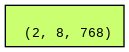

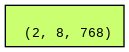

In [27]:
import torch
from torchviz import make_dot
from IPython.display import Image
from transformers import BertForSequenceClassification, BertTokenizer
import numpy as np
from torch.utils.data import DataLoader, Dataset
import os

# Sample text
texts = ["Hello, my dog is cute", "The weather is nice today"]
encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
sample_batch = {key: val.to(device) for key, val in encoded_inputs.items()}

# Prepare to capture activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Attach hooks to specific layers
model.bert.encoder.layer[0].output.register_forward_hook(get_activation('layer0_output'))
model.bert.encoder.layer[11].output.register_forward_hook(get_activation('layer11_output'))

# Forward pass to populate activations
with torch.no_grad():
    outputs = model(**sample_batch)

# Visualization setup
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/Project'
os.makedirs(checkpoint_path, exist_ok=True)

# Generate and save visualizations
for layer_name, act in activations.items():
    graph = make_dot(act, params=dict(list(model.named_parameters())))
    graph_path = f'{checkpoint_path}/{layer_name}'
    graph.render(graph_path, format='png')

    # Display the graph in Colab
    display(Image(f'{graph_path}.png'))

In [28]:
# Install the bertviz library
!pip install bertviz

from bertviz import head_view
from transformers import BertTokenizer, BertModel

# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

# Encode text and run model
inputs = tokenizer.encode("The capital of France is Paris.", return_tensors='pt')
outputs = model(inputs)

# Visualize attention
attention = outputs[-1]  # Get the attention weights from the output
tokens = tokenizer.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 13.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

In [29]:
#print(model)
!pip install torchinfo
from torchinfo import summary

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
summary(model, input_size=(1, 768))  # input_size should match the input dimension of your model


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [32]:
!pip install transformers torch onnx netron pyngrok


In [33]:
import os
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from pyngrok import ngrok

# Set up the model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.eval()  # Important: ensure the model is in evaluation mode

# Sample input text for the model
texts = ["Hello, my dog is cute", "The weather is nice today"]
encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Generate sample input for the model in the correct format
sample_batch = {key: val.to(device) for key, val in encoded_inputs.items()}

# Export the model to ONNX
output_model_path = '/content/drive/My Drive/Colab Notebooks/Project/model.onnx'

# Generate a dummy input that matches the input size expected by the model
dummy_input = next(iter(sample_batch.values())).to(device)

# Export to ONNX format
torch.onnx.export(model,
                  dummy_input,
                  output_model_path,
                  export_params=True,
                  opset_version=11,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},
                                'output' : {0 : 'batch_size'}})

# Start the Netron server
os.system(f"netron -p 8080 {output_model_path} &")

# Open a HTTP tunnel on port 8080 for the Netron server
public_url = ngrok.connect(port=8080)
print('Netron URL:', public_url)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ERROR:pyngrok.process.ngrok:t=2024-04-21T17:15:34+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-04-21T17:15:34+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.